# Compare QTLs for tomato fruit shape & potato tuber shape

## Background

Reference tomatoes have a round fruit shape while the reference potatoes have an elongated tuber shape. Recently published article (<a href="https://dx.doi.org/10.1038%2Fs41467-018-07216-8">Wu et al., 2018</a>) reveals that the SLOFP20 gene present on the tomato chromosome 10 is responsible for round fruits. However, this gene does not have an ortholog in the reference potato genome (DM), which results in elongated tuber. This notebook is used to map the QTL regions in both tomato and potato. First, genes in the QTLs are classified into three categories: i) corresponding genes (orthologs) between tomato and potato, ii) tomato genes with no orthologs in potato and iii) vice versa. For each category, GO annotations are retrieved and then compared among the categories.

## Initialization

In [1]:
from diagrams import DIAGRAMS
from IPython.display import Image,SVG
import requests, pandas as pd

url = "http://pbg-ld.candygene-nlesc.surf-hosted.nl:8088/api/candYgene/queries"

QTL for fruit shape in tomatoes on chromosome 10 is marked by the genes Solyc10g075170 and Solyc10g076240. Similarly QTL for tuber shape in potatoes on chromosome 10 is marked by the genes PGSC0003DMG400006678 and PGSC0003DMG400020801.


In [2]:
#potato
pg1 = "PGSC0003DMG400006678"
pg2 = "PGSC0003DMG400020801"
#tomato
tg1 = "Solyc10g075170.1"
tg2 = "Solyc10g076240.1"

## Tomato

### Find co-ordinates of the QTL interval
Search locations of genes, and compute interval

In [3]:
try:
    resp1 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+tg1+"'"}, 
                        headers={"accept": "application/json"})
    resp2 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+tg2+"'"}, 
                        headers={"accept": "application/json"})
    intervalT = {}
    intervalT["chrom"] = resp1.json()["results"]["bindings"][0]["chrom"]["value"]
    intervalT["taxon_id"] = resp1.json()["results"]["bindings"][0]["taxon_id"]["value"]
    intervalT["begin_pos"] = int(resp1.json()["results"]["bindings"][0]["end_pos"]["value"])
    intervalT["end_pos"] = int(resp2.json()["results"]["bindings"][0]["begin_pos"]["value"])    
except:
    raise Exception("couldn't get interval for "+str(tg1)+" or "+str(tg2))
intervalT    

{'chrom': 'chromosome 10',
 'taxon_id': '4081',
 'begin_pos': 58895882,
 'end_pos': 59082990}

### List the candidate genes inside this QTL interval and search potato orthologs
List genes and potato orthologs inside this interval

Find tomato genes in interval

In [4]:
try:
    if intervalT["taxon_id"]=="4081":
        graph = "http://solgenomics.net/genome/Solanum_lycopersicum"
    else:
        raise Exception("unknown taxon_id "+str(intervalT["taxon_id"]))
    genes = requests.get(url+"/getFeaturesInInterval", 
                        params={"feature": "'protein_coding_gene'", "graph": graph,
                               "begin": intervalT["begin_pos"], "end": intervalT["end_pos"],
                               "chrom": intervalT["chrom"]}, 
                        headers={"accept": "application/json"})
    genesT_in_interval = []
    for gene in genes.json()["results"]["bindings"]:
        gene_id = gene["feature_id"]["value"]
        #get location
        location = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
        taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
        begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
        end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"])    
        genesT_in_interval.append([gene_id, chrom, begin_pos, end_pos, taxon_id])
    genesT_in_interval = pd.DataFrame(genesT_in_interval)
    genesT_in_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id"]
    genesT_in_interval = genesT_in_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get genes in interval "+str(intervalT["begin_pos"])+" - "+str(intervalT["begin_pos"])+" on "+str(intervalT["chrom"]))    
#display(genesT_in_interval)    

Find potato orthologs for these genes

In [5]:
try:
    ortholog_genesT_for_interval = []
    for gene_id,gene in genesT_in_interval.iterrows():
        orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        orthologsResult = orthologs.json()["results"]["bindings"]
        if len(orthologsResult)>0:
            for ortholog in orthologsResult:
                ortholog_id = ortholog["ortholog_id"]["value"]
                #get location
                location = requests.get(url+"/getFeatureLocation", 
                                params={"featureid": "'"+ortholog_id+"'"}, 
                                headers={"accept": "application/json"})
                chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
                taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
                begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
                end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
                ortholog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                     gene["end_pos"],gene["taxon_id"],ortholog_id,
                                                     chrom, begin_pos, end_pos, taxon_id])
        else:
            ortholog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                 gene["end_pos"],gene["taxon_id"], None, None,
                                                None, None, None])
    ortholog_genesT_for_interval = pd.DataFrame(ortholog_genesT_for_interval)            
    ortholog_genesT_for_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id", 
                                            "ortholog_gene_id", "ortholog_chrom", "ortholog_begin_pos",
                                            "ortholog_end_pos", "ortholog_taxon_id"]
    ortholog_genesT_for_interval = ortholog_genesT_for_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get orthologs")    

Number of orthologs for each gene

In [6]:
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(ortholog_genesT_for_interval.groupby(["gene_id"]).agg(aggregations))

ortholog_gene_id
                          nunique
gene_id                          
Solyc10g076170.1                0
Solyc10g076180.1                0
Solyc10g076190.1                1
Solyc10g076200.1                2
Solyc10g076210.1                2
Solyc10g076220.1                2
Solyc10g076230.1                1

### List orthologs
List orthologs for the genes found in the interval

In [7]:
index=pd.MultiIndex.from_tuples([tuple(x) for x in ortholog_genesT_for_interval[["chrom", "begin_pos", "end_pos", "ortholog_gene_id"]].to_records()], names=["gene_id", "chrom", "begin_pos", "end_pos", "ortholog_gene_id"])
display(ortholog_genesT_for_interval.set_index(index)[["ortholog_chrom", "ortholog_begin_pos", "ortholog_end_pos", "taxon_id"]])   

ortholog_chrom  \
gene_id          chrom         begin_pos end_pos  ortholog_gene_id                      
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                            None   
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                            None   
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948   chromosome 0   
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955   chromosome 0   
                                                  PGSC0003DMG400040954  chromosome 10   
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799  chromosome 10   
                                                  PGSC0003DMG400020800  chromosome 10   
Solyc10g076220.1 chromosome 10 59059828  59060961 PGSC0003DMG400020799  chromosome 10   
                                                  PGSC0003DMG400020800  chromosome 10   
Solyc10g076230.1 chromosome 10 59074041  59074647 PGSC0003DMG400020798  chromosome 10   

                                                                        ortholog_begin_pos  \
gene_id          chrom         begin_pos end_pos  ortholog_gene_id                           
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                                  NaN   
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                                  NaN   
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948          22096297.0   
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955          22098971.0   
                                                  PGSC0003DMG400040954          49170543.0   
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799          49151461.0   
                                                  PGSC0003DMG400020800          49084193.0   
Solyc10g076220.1 chromosome 10 59059828  59060961 PGSC0003DMG400020799          49151461.0   
                                                  PGSC0003DMG400020800          49084193.0   
Solyc10g076230.1 chromosome 10 59074041  59074647 PGSC0003DMG400020798          49172630.0   

                                                                        ortholog_end_pos  \
gene_id          chrom         begin_pos end_pos  ortholog_gene_id                         
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                                NaN   
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                                NaN   
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948        22097627.0   
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955        22100334.0   
                                                  PGSC0003DMG400040954        49171657.0   
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799        49152451.0   
                                                  PGSC0003DMG400020800        49085040.0   
Solyc10g076220.1 chromosome 10 59059828  59060961 PGSC0003DMG400020799        49152451.0   
                                                  PGSC0003DMG400020800        49085040.0   
Solyc10g076230.1 chromosome 10 59074041  59074647 PGSC0003DMG400020798        49173264.0   

                                                                       taxon_id  
gene_id          chrom         begin_pos end_pos  ortholog_gene_id               
Solyc10g076170.1 chromosome 10 58981351  58981887 NaN                      4081  
Solyc10g076180.1 chromosome 10 59006329  59007294 NaN                      4081  
Solyc10g076190.1 chromosome 10 59045991  59047132 PGSC0003DMG400011948     4081  
Solyc10g076200.1 chromosome 10 59051770  59052216 PGSC0003DMG400011955     4081  
                                                  PGSC0003DMG400040954     4081  
Solyc10g076210.1 chromosome 10 59054478  59055612 PGSC0003DMG400020799     4081  
                                                  PGSC0003DMG400020800     4081  
Solyc10g076220.1 chromosome 10

### Chromosomes for orthologs
Chromosomes containing the found orthologs

In [8]:
kauraggregations = {"ortholog_begin_pos" : ["min","max"], "ortholog_end_pos" : ["min","max"]}
display(ortholog_genesT_for_interval.groupby(["ortholog_taxon_id", "ortholog_chrom"]).agg(aggregations))

ortholog_gene_id
                                          nunique
ortholog_taxon_id ortholog_chrom                 
4113              chromosome 0                  2
                  chromosome 10                 4

### Diagram crosslinks
Create a diagram with crosslinks between found genes and orthologs

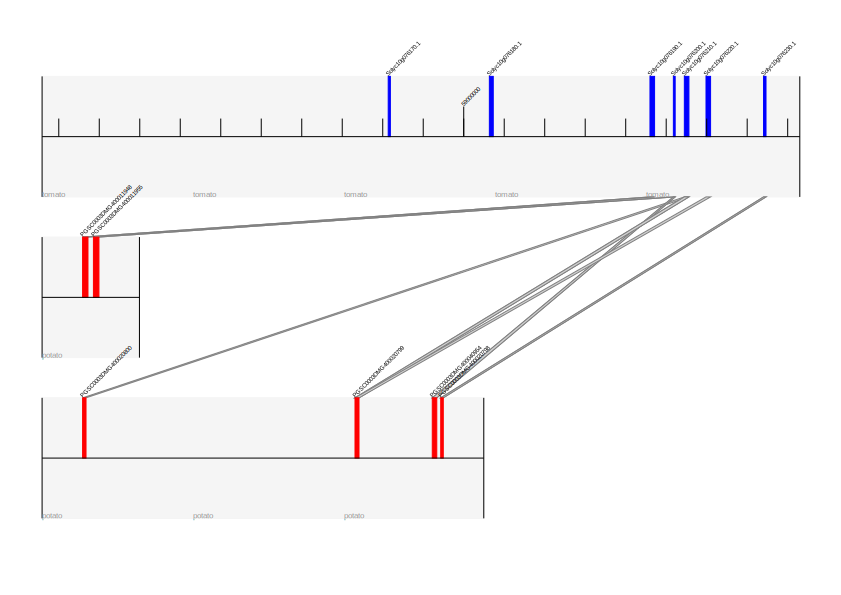

In [9]:
genesTdiagram = DIAGRAMS.crosslinks("tomato", "potato", intervalT, ortholog_genesT_for_interval)
tmpFilename = "tomato_"+tg1+"-"+tg2+"_crosslinks.svg"
genesTdiagram.write(tmpFilename, "svg")
SVG(tmpFilename)

## Potato
### Find interval
Find locations for genes, and compute interval

In [10]:
try:
    resp1 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+pg1+"'"}, 
                        headers={"accept": "application/json"})
    resp2 = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+pg2+"'"}, 
                        headers={"accept": "application/json"})
    intervalP = {}
    intervalP["chrom"] = resp1.json()["results"]["bindings"][0]["chrom"]["value"]
    intervalP["taxon_id"] = resp1.json()["results"]["bindings"][0]["taxon_id"]["value"]
    intervalP["begin_pos"] = int(resp1.json()["results"]["bindings"][0]["end_pos"]["value"])
    intervalP["end_pos"] = int(resp2.json()["results"]["bindings"][0]["begin_pos"]["value"])    
except:
    raise Exception("couldn't get interval for "+str(pg1)+" or "+str(pg2))
intervalP   

{'chrom': 'chromosome 10',
 'taxon_id': '4113',
 'begin_pos': 48982521,
 'end_pos': 49258672}

### Find genes and orthologs
Find genes and orthologs for interval

Find potato genes in interval

In [11]:
try:
    if intervalP["taxon_id"]=="4113":
        graph = "http://solgenomics.net/genome/Solanum_tuberosum"
    else:
        raise Exception("unknown taxon_id "+str(intervalP["taxon_id"]))
    genes = requests.get(url+"/getFeaturesInInterval", 
                        params={"feature": "'protein_coding_gene'", "graph": graph,
                               "begin": intervalP["begin_pos"], "end": intervalP["end_pos"],
                               "chrom": intervalP["chrom"]}, 
                        headers={"accept": "application/json"})
    genesP_in_interval = []
    for gene in genes.json()["results"]["bindings"]:
        gene_id = gene["feature_id"]["value"]
        #get location
        location = requests.get(url+"/getFeatureLocation", 
                        params={"featureid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
        taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
        begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
        end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"])    
        genesP_in_interval.append([gene_id, chrom, begin_pos, end_pos, taxon_id])
    genesP_in_interval = pd.DataFrame(genesP_in_interval)
    genesP_in_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id"]
    genesP_in_interval = genesP_in_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get genes in interval "+str(intervalP["begin_pos"])+" - "+str(intervalP["begin_pos"])+" on "+str(intervalP["chrom"]))    
#display(genesP_in_interval)    

Find tomato orthologs for these genes

In [12]:
try:
    ortholog_genesP_for_interval = []
    for gene_id,gene in genesP_in_interval.iterrows():
        orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        orthologsResult = orthologs.json()["results"]["bindings"]
        if len(orthologsResult)>0:
            for ortholog in orthologsResult:
                ortholog_id = ortholog["ortholog_id"]["value"]
                #get location
                location = requests.get(url+"/getFeatureLocation", 
                                params={"featureid": "'"+ortholog_id+"'"}, 
                                headers={"accept": "application/json"})
                chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
                taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
                begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
                end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
                ortholog_genesP_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                     gene["end_pos"],gene["taxon_id"],ortholog_id,
                                                     chrom, begin_pos, end_pos, taxon_id])
        else:
            ortholog_genesP_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                 gene["end_pos"],gene["taxon_id"], None, None,
                                                None, None, None])
    ortholog_genesP_for_interval = pd.DataFrame(ortholog_genesP_for_interval)            
    ortholog_genesP_for_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id", 
                                            "ortholog_gene_id", "ortholog_chrom", "ortholog_begin_pos",
                                            "ortholog_end_pos", "ortholog_taxon_id"]
    ortholog_genesP_for_interval = ortholog_genesP_for_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get orthologs")  

Number of orthologs for each gene

In [13]:
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(ortholog_genesP_for_interval.groupby(["gene_id"]).agg(aggregations))

ortholog_gene_id
                              nunique
gene_id                              
PGSC0003DMG400006679                0
PGSC0003DMG400006680                0
PGSC0003DMG400006681                0
PGSC0003DMG400020795                0
PGSC0003DMG400020797                0
PGSC0003DMG400020798                2
PGSC0003DMG400020799                2
PGSC0003DMG400020800                2
PGSC0003DMG400035649                0
PGSC0003DMG400039458                0
PGSC0003DMG400040544                2
PGSC0003DMG400040954                1
PGSC0003DMG400045482                0

### List orthologs
List orthologs for the genes found in the interval

In [14]:
index=pd.MultiIndex.from_tuples([tuple(x) for x in ortholog_genesP_for_interval[["chrom", "begin_pos", "end_pos", "ortholog_gene_id"]].to_records()], names=["gene_id", "chrom", "begin_pos", "end_pos", "ortholog_gene_id"])
display(ortholog_genesP_for_interval.set_index(index)[["ortholog_chrom", "ortholog_begin_pos", "ortholog_end_pos", "taxon_id"]])   

ortholog_chrom  \
gene_id              chrom         begin_pos end_pos  ortholog_gene_id                  
PGSC0003DMG400006679 chromosome 10 49022687  49023709 NaN                        None   
PGSC0003DMG400006680 chromosome 10 49040786  49046010 NaN                        None   
PGSC0003DMG400006681 chromosome 10 49064472  49065184 NaN                        None   
PGSC0003DMG400020795 chromosome 10 49247297  49254377 NaN                        None   
PGSC0003DMG400020797 chromosome 10 49199138  49201970 NaN                        None   
PGSC0003DMG400020798 chromosome 10 49172630  49173264 Solyc10g075120.1  chromosome 10   
                                                      Solyc10g076230.1  chromosome 10   
PGSC0003DMG400020799 chromosome 10 49151461  49152451 Solyc10g076210.1  chromosome 10   
                                                      Solyc10g076220.1  chromosome 10   
PGSC0003DMG400020800 chromosome 10 49084193  49085040 Solyc10g076210.1  chromosome 10   
                                                      Solyc10g076220.1  chromosome 10   
PGSC0003DMG400035649 chromosome 10 49174387  49174710 NaN                        None   
PGSC0003DMG400039458 chromosome 10 49235999  49240574 NaN                        None   
PGSC0003DMG400040544 chromosome 10 49108641  49111957 Solyc01g066890.1   chromosome 1   
                                                      Solyc07g041360.1   chromosome 7   
PGSC0003DMG400040954 chromosome 10 49170543  49171657 Solyc10g076200.1  chromosome 10   
PGSC0003DMG400045482 chromosome 10 49092329  49093552 NaN                        None   

                                                                        ortholog_begin_pos  \
gene_id              chrom         begin_pos end_pos  ortholog_gene_id                       
PGSC0003DMG400006679 chromosome 10 49022687  49023709 NaN                              NaN   
PGSC0003DMG400006680 chromosome 10 49040786  49046010 NaN                              NaN   
PGSC0003DMG400006681 chromosome 10 49064472  49065184 NaN                              NaN   
PGSC0003DMG400020795 chromosome 10 49247297  49254377 NaN                              NaN   
PGSC0003DMG400020797 chromosome 10 49199138  49201970 NaN                              NaN   
PGSC0003DMG400020798 chromosome 10 49172630  49173264 Solyc10g075120.1          58847992.0   
                                                      Solyc10g076230.1          59074041.0   
PGSC0003DMG400020799 chromosome 10 49151461  49152451 Solyc10g076210.1          59054478.0   
                                                      Solyc10g076220.1          59059828.0   
PGSC0003DMG400020800 chromosome 10 49084193  49085040 Solyc10g076210.1          59054478.0   
                                                      Solyc10g076220.1          59059828.0   
PGSC0003DMG400035649 chromosome 10 49174387  49174710 NaN                              NaN   
PGSC0003DMG400039458 chromosome 10 49235999  49240574 NaN                              NaN   
PGSC0003DMG400040544 chromosome 10 49108641  49111957 Solyc01g066890.1          75142075.0   
                                                      Solyc07g041360.1          52534390.0   
PGSC0003DMG400040954 chromosome 10 49170543  49171657 Solyc10g076200.1          59051770.0   
PGSC0003DMG400045482 chromosome 10 49092329  49093552 NaN                              NaN   

                                                                        ortholog_end_pos  \
gene_id              chrom         begin_pos end_pos  ortholog_gene_id                     
PGSC0003DMG400006679 chromosome 10 49022687  49023709 NaN                            NaN   
PGSC0003DMG400006680 chromosome 10 49040786  49046010 NaN                            NaN   
PGSC0003DMG400006681 chromosome 10 49064472  49065184 NaN                            NaN   
PGSC0003DMG400020795 chromosome 10 49247297  49254377 NaN                            NaN   
PGSC0003DMG400020797 chromosome 10 49199

### Chromosomes for orthologs
Chromosomes containing the found orthologs

In [15]:
kauraggregations = {"ortholog_begin_pos" : ["min","max"], "ortholog_end_pos" : ["min","max"]}
display(ortholog_genesP_for_interval.groupby(["ortholog_taxon_id", "ortholog_chrom"]).agg(aggregations))

ortholog_gene_id
                                          nunique
ortholog_taxon_id ortholog_chrom                 
4081              chromosome 1                  1
                  chromosome 10                 5
                  chromosome 7                  1

### Diagram crosslinks
Create a diagram with crosslinks between found genes and orthologs

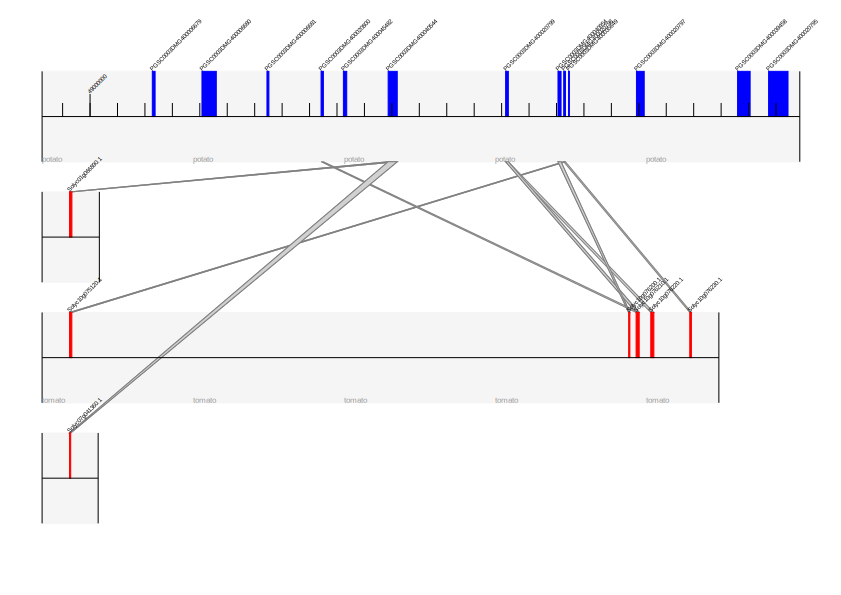

In [16]:
genesPdiagram = DIAGRAMS.crosslinks("potato", "tomato", intervalP, ortholog_genesP_for_interval)
tmpFilename = "potato_"+pg1+"-"+pg2+".svg"
genesPdiagram.write(tmpFilename, "svg")
SVG(tmpFilename)

# Annotations
Compare GO annotatios in all three classes

Genes, orthologs for potato and tomato and annotations

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [18]:
setT = set(genesT_in_interval.index.unique())
setP = set(genesP_in_interval.index.unique())
setTP = setT & set(ortholog_genesP_for_interval["ortholog_gene_id"].dropna().unique())
setPT = setP & set(ortholog_genesT_for_interval["ortholog_gene_id"].dropna().unique())
setT = setT - setTP
setP = setP - setPT

In [19]:
# debug
print('setT(%d) = %s' % (len(setT), setT))
print('setP(%d) = %s' % (len(setP), setP))
print('setTP(%d) = %s' % (len(setTP), setTP))

setT(3) = {'Solyc10g076190.1', 'Solyc10g076170.1', 'Solyc10g076180.1'}
setP(9) = {'PGSC0003DMG400006681', 'PGSC0003DMG400020795', 'PGSC0003DMG400045482', 'PGSC0003DMG400039458', 'PGSC0003DMG400006680', 'PGSC0003DMG400035649', 'PGSC0003DMG400020797', 'PGSC0003DMG400006679', 'PGSC0003DMG400040544'}
setTP(4) = {'Solyc10g076200.1', 'Solyc10g076220.1', 'Solyc10g076210.1', 'Solyc10g076230.1'}


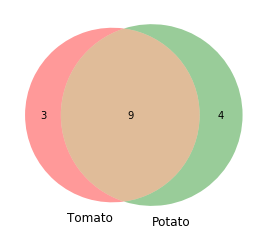

In [20]:
venn2(subsets = (len(setT), len(setTP), len(setP)), set_labels = ("Tomato", "Potato"))
#venn2(subsets = (1,2,3), set_labels = ("Tomato", "Potato"))
plt.show()

## Only in Tomato interval

In [21]:
print(*setT, sep = "\n")

Solyc10g076190.1
Solyc10g076170.1
Solyc10g076180.1


In [22]:
try:
    termsT = []
    for gene_id in setT:
        annotations = requests.get(url+"/getGeneAnnotations", 
                                   params={"geneid": "'"+gene_id+"'"}, 
                                   headers={"accept": "application/json"})        
        for annotation in annotations.json()["results"]["bindings"]:
            uniprot_goa = annotation["uniprot_goa"]["value"].strip()
            if uniprot_goa=="":
                termsT.append([gene_id, None])
            else:
                for go_id in uniprot_goa.split(","):                    
                    termsT.append([gene_id, go_id.strip()])
            break        
    termsT = pd.DataFrame(termsT)
    termsT.columns = ["gene_id", "go_id"]
    termsT = termsT.set_index(["gene_id"])
except:
    raise Exception("couldn't get terms for genes") 

In [23]:
print(*set([go_id for go_id in termsT["go_id"] if not (go_id == None)]), sep="\n")

GO:0004601 [peroxidase activity]; GO:0005576 [extracellular region]; GO:0006979 [response to oxidative stress]; GO:0020037 [heme binding]; GO:0042744 [hydrogen peroxide catabolic process]; GO:0046872 [metal ion binding]
DNA-templated]
GO:0003677 [DNA binding]; GO:0045892 [negative regulation of transcription


In [ ]:
termsT.set_index(["go_id"], append=True)

Empty DataFrame
Columns: []
Index: [(Solyc10g076190.1, GO:0004601 [peroxidase activity]; GO:0005576 [extracellular region]; GO:0006979 [response to oxidative stress]; GO:0020037 [heme binding]; GO:0042744 [hydrogen peroxide catabolic process]; GO:0046872 [metal ion binding]), (Solyc10g076170.1, nan), (Solyc10g076180.1, GO:0003677 [DNA binding]; GO:0045892 [negative regulation of transcription), (Solyc10g076180.1, DNA-templated])]

## Only in Potato

In [ ]:
print(*setP, sep = "\n")

PGSC0003DMG400006681
PGSC0003DMG400020795
PGSC0003DMG400045482
PGSC0003DMG400039458
PGSC0003DMG400006680
PGSC0003DMG400035649
PGSC0003DMG400020797
PGSC0003DMG400006679
PGSC0003DMG400040544


In [ ]:
try:
    termsP = []
    for gene_id in setP:
        annotations = requests.get(url+"/getGeneAnnotations", 
                                   params={"geneid": "'"+gene_id+"'"}, 
                                   headers={"accept": "application/json"})        
        for annotation in annotations.json()["results"]["bindings"]:
            uniprot_goa = annotation["uniprot_goa"]["value"].strip()
            if uniprot_goa=="":
                termsP.append([gene_id, None])
            else:
                for go_id in uniprot_goa.split(";"):                    
                    termsP.append([gene_id, go_id.strip()])
            break        
    termsP = pd.DataFrame(termsP)
    termsP.columns = ["gene_id", "go_id"]
    termsP = termsP.set_index(["gene_id"])
except:
    raise Exception("couldn't get terms for genes") 

In [ ]:
print(*set([go_id for go_id in termsP["go_id"] if not (go_id == None)]), sep="\n")

GO:0006979 [response to oxidative stress]
GO:0042744 [hydrogen peroxide catabolic process]
GO:0046872 [metal ion binding]
GO:0004601 [peroxidase activity]
GO:0020037 [heme binding]


In [ ]:
termsP.set_index(["go_id"], append=True)

Empty DataFrame
Columns: []
Index: [(PGSC0003DMG400006681, GO:0004601 [peroxidase activity]), (PGSC0003DMG400006681, GO:0006979 [response to oxidative stress]), (PGSC0003DMG400006681, GO:0020037 [heme binding]), (PGSC0003DMG400020795, GO:0004601 [peroxidase activity]), (PGSC0003DMG400020795, GO:0006979 [response to oxidative stress]), (PGSC0003DMG400020795, GO:0020037 [heme binding]), (PGSC0003DMG400045482, nan), (PGSC0003DMG400039458, nan), (PGSC0003DMG400006680, GO:0004601 [peroxidase activity]), (PGSC0003DMG400006680, GO:0006979 [response to oxidative stress]), (PGSC0003DMG400006680, GO:0020037 [heme binding]), (PGSC0003DMG400035649, nan), (PGSC0003DMG400020797, nan), (PGSC0003DMG400006679, GO:0004601 [peroxidase activity]), (PGSC0003DMG400006679, GO:0006979 [response to oxidative stress]), (PGSC0003DMG400006679, GO:0020037 [heme binding]), (PGSC0003DMG400006679, GO:0042744 [hydrogen peroxide catabolic process]), (PGSC0003DMG400006679, GO:0046872 [metal ion binding]), (PGSC0003DMG400040544, nan)]

## Both in Tomato and Potato

In [ ]:
print(*setTP, sep = "\n")
#print(*setPT, sep = "\n")

Solyc10g076200.1
Solyc10g076220.1
Solyc10g076210.1
Solyc10g076230.1


In [ ]:
try:
    termsTP = []
    for gene_id in setTP:
        annotations = requests.get(url+"/getGeneAnnotations", 
                                   params={"geneid": "'"+gene_id+"'"}, 
                                   headers={"accept": "application/json"})        
        for annotation in annotations.json()["results"]["bindings"]:
            uniprot_goa = annotation["uniprot_goa"]["value"].strip()
            if uniprot_goa=="":
                termsTP.append([gene_id, None])
            else:
                for go_id in uniprot_goa.split(";"):                    
                    termsTP.append([gene_id, go_id.strip()])
            break        
    termsTP = pd.DataFrame(termsTP)
    termsTP.columns = ["gene_id", "go_id"]
    termsTP = termsTP.set_index(["gene_id"])
except:
    raise Exception("couldn't get terms for genes")

In [ ]:
print(*set([go_id for go_id in termsTP["go_id"] if not (go_id == None)]), sep="\n")

GO:0006869 [lipid transport]
GO:0016020 [membrane]
GO:0006979 [response to oxidative stress]
GO:0042744 [hydrogen peroxide catabolic process]
GO:0008289 [lipid binding]
GO:0004601 [peroxidase activity]
GO:0020037 [heme binding]
GO:0046872 [metal ion binding]
GO:0005576 [extracellular region]


In [ ]:
termsTP.set_index(["go_id"], append=True)

Empty DataFrame
Columns: []
Index: [(Solyc10g076200.1, GO:0006869 [lipid transport]), (Solyc10g076200.1, GO:0008289 [lipid binding]), (Solyc10g076200.1, GO:0016020 [membrane]), (Solyc10g076220.1, GO:0004601 [peroxidase activity]), (Solyc10g076220.1, GO:0005576 [extracellular region]), (Solyc10g076220.1, GO:0006979 [response to oxidative stress]), (Solyc10g076220.1, GO:0020037 [heme binding]), (Solyc10g076220.1, GO:0042744 [hydrogen peroxide catabolic process]), (Solyc10g076220.1, GO:0046872 [metal ion binding]), (Solyc10g076210.1, GO:0004601 [peroxidase activity]), (Solyc10g076210.1, GO:0005576 [extracellular region]), (Solyc10g076210.1, GO:0006979 [response to oxidative stress]), (Solyc10g076210.1, GO:0020037 [heme binding]), (Solyc10g076210.1, GO:0042744 [hydrogen peroxide catabolic process]), (Solyc10g076210.1, GO:0046872 [metal ion binding]), (Solyc10g076230.1, GO:0004601 [peroxidase activity]), (Solyc10g076230.1, GO:0006979 [response to oxidative stress]), (Solyc10g076230.1, GO:0020037 [heme binding])]

## Exploring the Annotations of Gene *Solyc10g076180.1*

- GO Annotation
- PPI 
- STRING
- KEGG
- ALL Orthologs
- Species with no Orthologs

In [ ]:
try:
    ortholog_paralog_genesT_for_interval = []
    for gene_id,gene in genesT_in_interval.iterrows():
        #get paralogs, and then orthologs
        paralogs = requests.get(url+"/getParalogs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        for paralog in paralogs.json()["results"]["bindings"]:
            paralog_id = paralog["paralog_id"]["value"]
            #get orthologs for paralog
            orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+paralog_id+"'"}, 
                        headers={"accept": "application/json"})
            for ortholog in orthologs.json()["results"]["bindings"]:
                ortholog_id = ortholog["ortholog_id"]["value"]
                #get location
                location = requests.get(url+"/getFeatureLocation", 
                                params={"featureid": "'"+ortholog_id+"'"}, 
                                headers={"accept": "application/json"})
                chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
                taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
                begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
                end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
                ortholog_paralog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                             gene["end_pos"],gene["taxon_id"],paralog_id,
                                                             "PARALOG", ortholog_id,
                                                             chrom, begin_pos, end_pos, taxon_id])
        #get direct orthologs
        orthologs = requests.get(url+"/getOrthologs", 
                        params={"geneid": "'"+gene_id+"'"}, 
                        headers={"accept": "application/json"})
        for ortholog in orthologs.json()["results"]["bindings"]:
            ortholog_id = ortholog["ortholog_id"]["value"]
            #get location
            location = requests.get(url+"/getFeatureLocation", 
                            params={"featureid": "'"+ortholog_id+"'"}, 
                            headers={"accept": "application/json"})
            chrom = location.json()["results"]["bindings"][0]["chrom"]["value"]
            taxon_id = location.json()["results"]["bindings"][0]["taxon_id"]["value"]
            begin_pos = int(location.json()["results"]["bindings"][0]["begin_pos"]["value"])
            end_pos = int(location.json()["results"]["bindings"][0]["end_pos"]["value"]) 
            ortholog_paralog_genesT_for_interval.append([gene_id, gene["chrom"],gene["begin_pos"],
                                                 gene["end_pos"],gene["taxon_id"],None, "ORTHOLOG", ortholog_id,
                                                 chrom, begin_pos, end_pos, taxon_id])    
    #create dataframe        
    ortholog_paralog_genesT_for_interval = pd.DataFrame(ortholog_paralog_genesT_for_interval)            
    ortholog_paralog_genesT_for_interval.columns = ["gene_id", "chrom", "begin_pos", "end_pos", "taxon_id", "paralog_gene_id",
                                            "path", "ortholog_gene_id", "ortholog_chrom", "ortholog_begin_pos",
                                            "ortholog_end_pos", "ortholog_taxon_id"]
    ortholog_paralog_genesT_for_interval = ortholog_paralog_genesT_for_interval.set_index(["gene_id"])
except:
    raise Exception("couldn't get orthologs")  

Number of orthologs for each gene

In [ ]:
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(ortholog_paralog_genesT_for_interval.groupby(["gene_id"]).agg(aggregations))

In [ ]:
index=pd.MultiIndex.from_tuples([tuple(x) for x in ortholog_paralog_genesT_for_interval[["chrom", "begin_pos", "end_pos", "paralog_gene_id", "ortholog_gene_id"]].to_records()], names=["gene_id", "chrom", "begin_pos", "end_pos", "paralog_gene_id", "ortholog_gene_id"])
display(ortholog_paralog_genesT_for_interval.set_index(index)[["path", "ortholog_chrom", "ortholog_begin_pos", "ortholog_end_pos"]])      